In [10]:
import torch
import os
import pandas as pd
import scipy
import torchvision
from torch import optim,nn
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [13]:
# Params

# ae complexity
img_size = 288
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size,img_size)),
    #T.RandomResizedCrop(image_size), # data augmentation
    # T.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
train_batch = 128
test_batch = 32
lr=1e-2
data_root = "/data/students/louis/standfordcars/standfordcars"
epochs = 50


In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=kwargs["input_shape"], out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        # self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        # self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=kwargs["input_shape"])
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        # x = F.relu(self.nc5(x))
        # x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x


class StanfordCars(Dataset):

    def __init__(self, root: str, split: str = "train", transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self._split = split
        self._base_folder = root

        if self._split == "train":
            self._images_base_path = self._base_folder + "/train/"
        else:
            self._images_base_path = self._base_folder + "/test/"

        annotation = pd.DataFrame({"Filename":os.listdir(self._images_base_path)})

        self._samples = [
            (
                str(self._images_base_path + annot),
            )
            for annot in annotation["Filename"]
        ]


    def __len__(self) -> int:
        return len(self._samples)

    def __getitem__(self, idx: int):
        """Returns pil_image and class_id for given index"""
        image_path = self._samples[idx]
        target = 0
        
        pil_image = Image.open(image_path[0]).convert("RGB")

        if self.transform is not None:
            pil_image = self.transform(pil_image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return (pil_image, target)


train_dataset = StanfordCars(root=data_root,split ="test",transform=transform)
test_dataset = StanfordCars(root=data_root,split ="train",transform=transform)

train_loader = torch.utils.data.DataLoader( train_dataset, batch_size=train_batch, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(  test_dataset, test_batch, shuffle=False, num_workers=4)


In [57]:
class CAE(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
       
        super().__init__()
        c_hid = base_channel_size
        self.in_latent = int(img_size/8)

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*3*self.in_latent*self.in_latent),
            act_fn()
        )
    
        self.encoder = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 288x288 => 144x144
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 144x144 => 72x72
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 72x72 => 36x36
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(in_features= 2*self.in_latent*self.in_latent*c_hid, out_features= latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 36x36 => 72x72
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 72x72 => 144x144
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 144x144 => 288x288
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
            x = self.encoder(x)
            x = self.linear(x)
            x = x.reshape(x.shape[0], -1, self.in_latent, self.in_latent)
            x = self.decoder(x)
            return x

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu",0)
print(device)

# model = AE(input_shape=img_size*img_size*3).to(device)
model = CAE(3,3,1000).to(device)

# create an optimizer object
optimizer = optim.Adam(model.parameters(), lr)

# mean-squared error loss
criterion = nn.MSELoss()


cuda:0


In [58]:


restored_imgs = []
losses = []
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        
        # batch_features = batch_features.view(-1, img_size*img_size*3).to(device)
        batch_features = batch_features.to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses.append(loss)
    restored_imgs.append((epochs, batch_features, outputs))
 
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

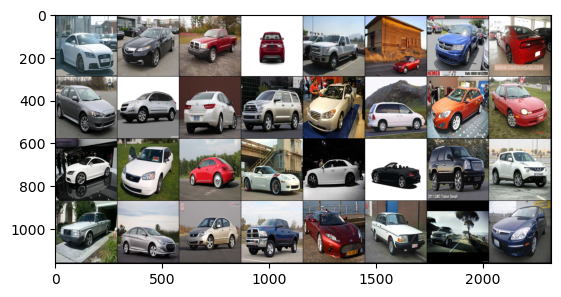

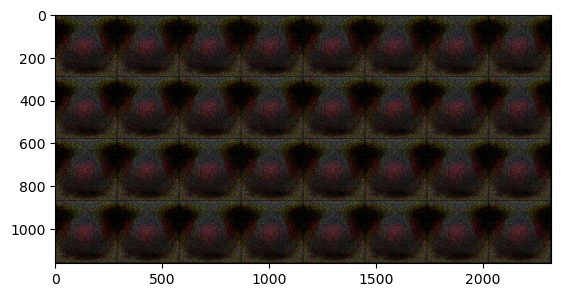

In [14]:

dataiter = iter(test_loader)
images, labels = dataiter.next()

def imshowo(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshowo(torchvision.utils.make_grid(images))


outputs = model(images.view(-1, img_size*img_size*3).to(device))
rep = torch.Tensor.cpu(outputs).detach()
imshowo(torchvision.utils.make_grid(rep.view(test_batch,3,img_size,img_size)))